## Effect of tau rescalings on emulator predictions

First of all compare the parameter limits and hyperparameters with and without nearest tau rescalings

In [1]:
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import cProfile
import emcee
import corner
import copy
# our own modules
import simplest_emulator
import linear_emulator
import gp_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import pressure_model
import lya_theory
import likelihood
import emcee_sampler
import data_MPGADGET
import z_emulator
import p1d_arxiv

In [2]:
import matplotlib
font = {'size'   : 14}

matplotlib.rc('font', **font)

In [3]:
test_sim_num=16
skewers_label='Ns500_wM0.05'
#skewers_label=None
#basedir="/p1d_emulator/sim_suites/emulator_256_28082019/"
basedir="/p1d_emulator/sim_suites/Australia20/"
#basedir=repo+"/p1d_emulator/sim_suites/emulator_256_15072019/"
p1d_label=None
undersample_z=12
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
max_arxiv_size=None
kmax_Mpc=8
z_list=None

In [4]:
truth=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,pick_sim_number=test_sim_num,
                            drop_temp_rescalings=True,skewers_label=skewers_label)
## Set up k bins for emulator call
k_test=truth.data[1]["k_Mpc"][1:]
k_test=k_test[k_test<7]
print(len(truth.data))

9


In [5]:
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=True,z_max=4,drop_sim_number=test_sim_num,
                            drop_temp_rescalings=True,skewers_label=skewers_label)


In [6]:
arxiv_tau=p1d_arxiv.ArxivP1D(basedir=basedir,
                            drop_tau_rescalings=False,z_max=4,drop_sim_number=test_sim_num,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [7]:
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=4,
                                verbose=False,paramList=paramList,train=True,
                                emu_type="k_bin",passArxiv=arxiv,kmax_Mpc=8,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

 /home/chris/.local/lib/python3.5/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 261 points
Optimised


In [8]:
emu_tau=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=4,
                                verbose=False,paramList=paramList,train=True,kmax_Mpc=8,
                                emu_type="k_bin",passArxiv=arxiv_tau,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)

Training GP on 783 points


 /home/chris/.local/lib/python3.5/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Optimised


In [10]:
emu_tau_samehyp=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=4,
                                verbose=False,paramList=paramList,train=False,kmax_Mpc=8,
                                emu_type="k_bin",passArxiv=arxiv_tau,
                                drop_tau_rescalings=True,
                                drop_temp_rescalings=True)


 /home/chris/.local/lib/python3.5/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


In [11]:
emu_tau_samehyp.load_hyperparams(emu.gp.param_array,emu.paramLimits)

 /home/chris/.local/lib/python3.5/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


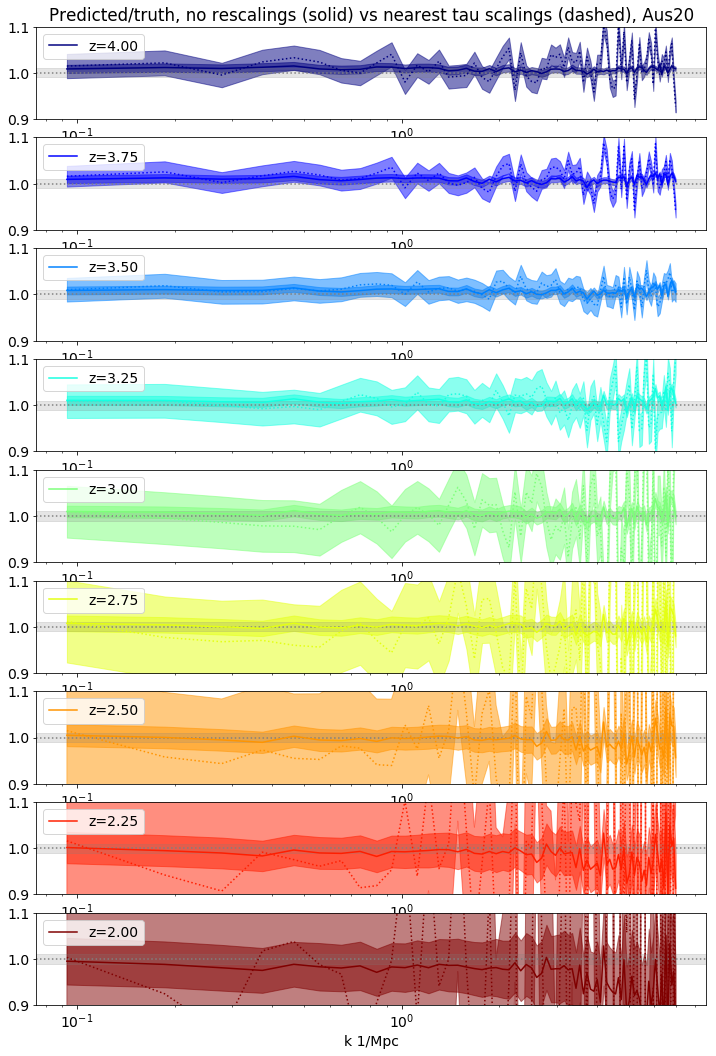

In [17]:
plt.figure(figsize=[12,18])
dex=0
for aa,item in enumerate(truth.data):
    plt.subplot(len(truth.data),1,aa+1)
    if aa==0:
        plt.title("Predicted/truth, no rescalings (solid) vs nearest tau scalings (dashed), Aus20")
    col = plt.cm.jet(dex/(len(truth.data)-1))
    dex+=1
    emu_call={}
    for param in paramList:
        emu_call[param]=item[param]
    pred,err=emu.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    pred_tau,err_tau=emu_tau.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    plt.axhspan(0.99,1.01,color="gray",alpha=0.2)
    plt.axhline(1,linestyle=":",color="gray")
    ## Plot z with different limits
    plt.plot(k_test,pred/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="solid",label="z=%.2f" % item["z"])
    plt.fill_between(k_test,(pred+np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],
            (pred-np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],alpha=0.5,color=col)
    plt.plot(k_test,pred_tau/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="dotted")
    plt.fill_between(k_test,(pred_tau+np.sqrt(np.diag(err_tau)))/item["p1d_Mpc"][1:(len(k_test)+1)],
            (pred_tau-np.sqrt(np.diag(err_tau)))/item["p1d_Mpc"][1:(len(k_test)+1)],alpha=0.5,color=col)

    plt.xscale("log")
    plt.ylim(0.9,1.1)
    plt.legend()

#plt.xscale("log")
plt.xlabel("k 1/Mpc")
plt.savefig("tau_scalings_aus.pdf")

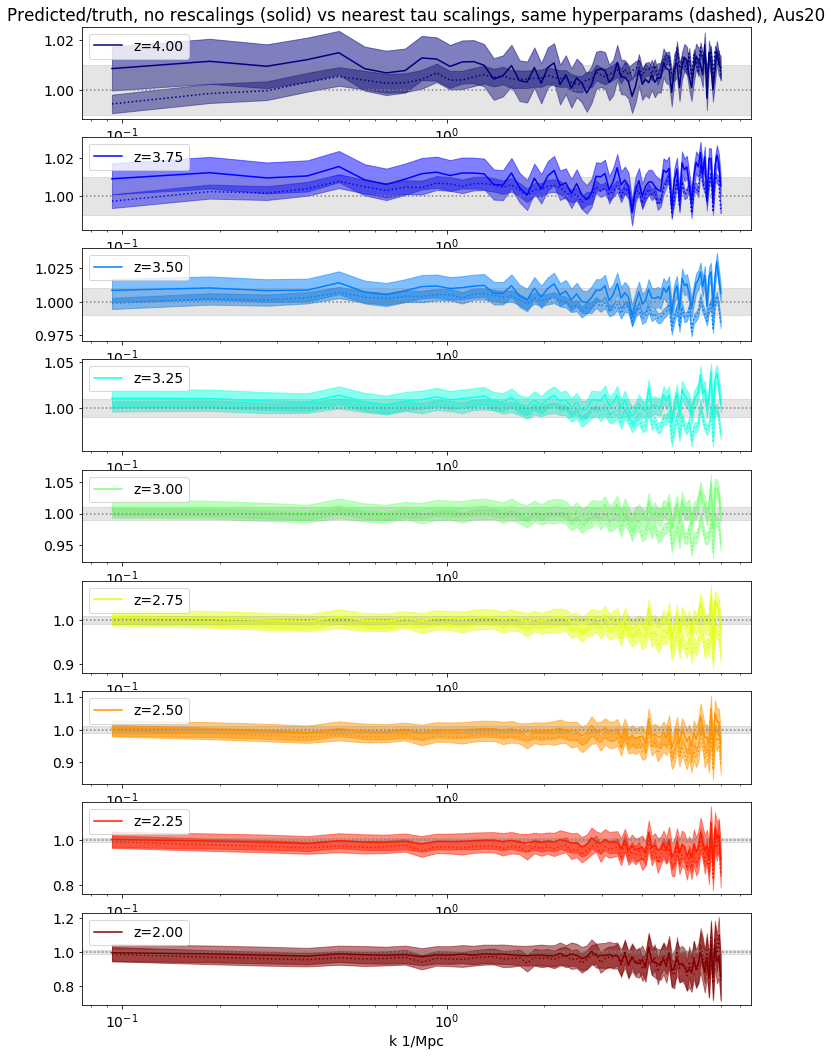

In [20]:
plt.figure(figsize=[12,18])
dex=0
for aa,item in enumerate(truth.data):
    plt.subplot(len(truth.data),1,aa+1)
    if aa==0:
        plt.title("Predicted/truth, no rescalings (solid) vs nearest tau scalings, same hyperparams (dashed), Aus20")
    col = plt.cm.jet(dex/(len(truth.data)-1))
    dex+=1
    emu_call={}
    for param in paramList:
        emu_call[param]=item[param]
    pred,err=emu.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    pred_tau,err_tau=emu_tau_samehyp.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    plt.axhspan(0.99,1.01,color="gray",alpha=0.2)
    plt.axhline(1,linestyle=":",color="gray")
    ## Plot z with different limits
    plt.plot(k_test,pred/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="solid",label="z=%.2f" % item["z"])
    plt.fill_between(k_test,(pred+np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],
            (pred-np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],alpha=0.5,color=col)
    plt.plot(k_test,pred_tau/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="dotted")
    plt.fill_between(k_test,(pred_tau+np.sqrt(np.diag(err_tau)))/item["p1d_Mpc"][1:(len(k_test)+1)],
            (pred_tau-np.sqrt(np.diag(err_tau)))/item["p1d_Mpc"][1:(len(k_test)+1)],alpha=0.5,color=col)
    plt.xscale("log")
    #plt.ylim(0.9,1.1)
    plt.legend()

#plt.xscale("log")
plt.xlabel("k 1/Mpc")
plt.savefig("tau_scalings_same_aus.pdf")

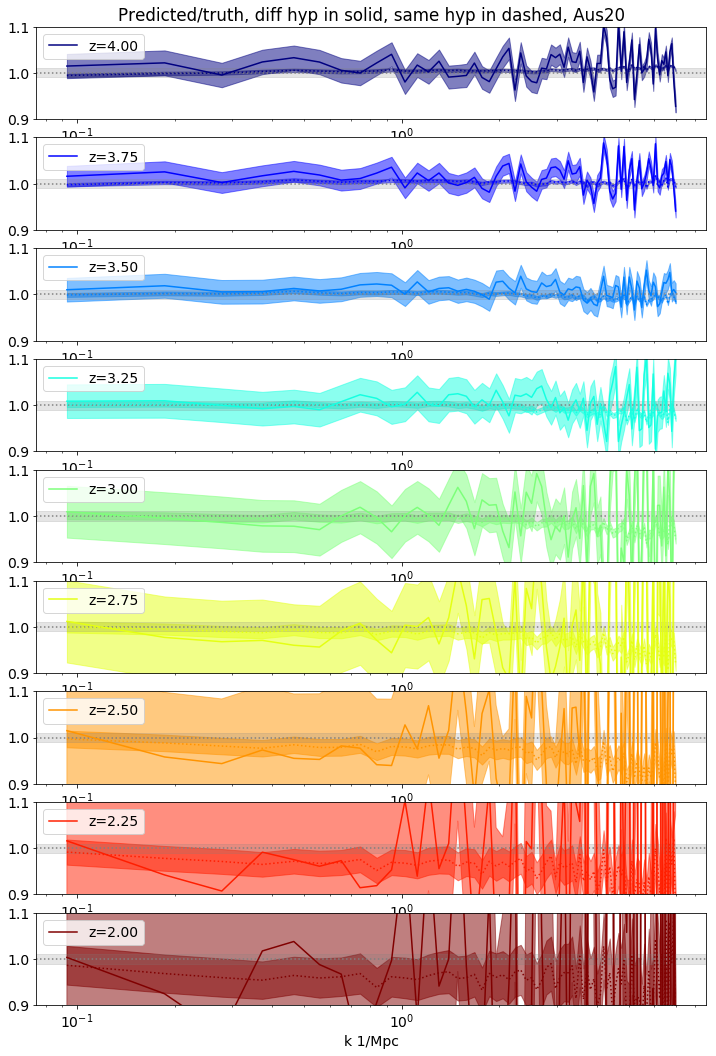

In [19]:
plt.figure(figsize=[12,18])
dex=0
for aa,item in enumerate(truth.data):
    plt.subplot(len(truth.data),1,aa+1)
    if aa==0:
        plt.title("Predicted/truth, diff hyp in solid, same hyp in dashed, Aus20")
    col = plt.cm.jet(dex/(len(truth.data)-1))
    dex+=1
    emu_call={}
    for param in paramList:
        emu_call[param]=item[param]
    pred,err=emu_tau.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    pred_tau,err_tau=emu_tau_samehyp.emulate_p1d_Mpc(emu_call,k_test,True,item["z"])
    plt.axhspan(0.99,1.01,color="gray",alpha=0.2)
    plt.axhline(1,linestyle=":",color="gray")
    ## Plot z with different limits
    plt.plot(k_test,pred/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="solid",label="z=%.2f" % item["z"])
    plt.fill_between(k_test,(pred+np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],
            (pred-np.sqrt(np.diag(err)))/item["p1d_Mpc"][1:(len(k_test)+1)],alpha=0.5,color=col)
    plt.plot(k_test,pred_tau/item["p1d_Mpc"][1:(len(k_test)+1)],color=col,linestyle="dotted")
    plt.fill_between(k_test,(pred_tau+np.sqrt(np.diag(err_tau)))/item["p1d_Mpc"][1:(len(k_test)+1)],
            (pred_tau-np.sqrt(np.diag(err_tau)))/item["p1d_Mpc"][1:(len(k_test)+1)],alpha=0.5,color=col)
    plt.xscale("log")
    plt.ylim(0.9,1.1)
    plt.legend()

#plt.xscale("log")
plt.xlabel("k 1/Mpc")
plt.savefig("tau_scalings_compare_aus.pdf")